# An Introduction to the Amazon Fraud Detector API  
#### Supervised fraud detection  
-------

## Introduction
-------

Amazon Fraud Detector is a fully managed service that makes it easy to identify potentially fraudulent online activities such as online payment fraud and the creation of fake accounts. Fraud Detector capitalizes on the latest advances in machine learning (ML) and 20 years of fraud detection expertise from AWS and Amazon.com to automatically identify potentially fraudulent activity so you can catch more fraud faster.

If you would like to know more, please check out [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 

In [22]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
import sys
import time
import json
import uuid 
from datetime import datetime

# -- AWS stuff -- 
import boto3
import sagemaker
from sagemaker import get_execution_role

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline 

In [23]:
# -- initialize the AFD client 
client = boto3.client('frauddetector')

# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")

### 1. Setup 
-----

***To get started ***  

1. Load the config.json that was created for you
2. The properties EVENT_TYPE, ENTITY_TYPE, MODEL_NAME and DETECTOR_NAME will all be set for you based on your configuration. The names you named in your CloudFormation template will be set here.
3. Load ARN of you local instance
4. Let the source file from S3 be specified

Then you can interactively exeucte the code cells in the notebook, no need to change anything unless you want to. 


<div class="alert alert-info"> <strong> Fraud Detector Components </strong>
Fraud Detector Components:  EVENT_TYPE is a business activity that you want evaluated for fraud risk. ENTITY_TYPE represents the "what or who" that is performing the event you want to evaluate. MODEL_NAME is the name of your supervised machine learning model that Fraud Detector trains on your behalf. DETECTOR_NAME is the name of the detector that contains the detection logic (model and rules) that you apply to events that you want to evaluate for fraud.

</div>

-----

### Bucket, File, and ARN Role

Bucket, ARN and Model Name Identify the following assets. S3_BUCKET is the name of the bucket where your file lives. S3_FILE is the URL to your s3 file. ARN_ROLE is the data access role "ARN" for the training data source.

<div class="alert alert-info"><strong> Bucket, ARN and Model Name </strong>

Identify the following assets. S3_BUCKET is the name of the bucket where your file lives. S3_FILE is the URL to your s3 file. ARN_ROLE is the data access role "ARN" for the training data source.

</div>

In [27]:
with open("config.json") as json_file:
    config = json.load(json_file)

In [28]:
# -- This is all you need to fill out. Once complete simply interactively run each code cell. --  

ENTITY_TYPE    = config["ENTITY_TYPE"]
ENTITY_DESC    = "entity description: {0}".format(sufx)

EVENT_TYPE     = config["EVENT_TYPE"]
EVENT_DESC     = "example event description: {0}".format(sufx)

MODEL_NAME     = config["MODEL_NAME"]
MODEL_DESC     = "model trained on: {0}".format(sufx)

DETECTOR_NAME  = config["DETECTOR_NAME"]                    
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx)

ARN_ROLE       = get_execution_role()
S3_BUCKET      = config["S3_BUCKET"]
S3_FILE        = config["S3_FILE"]
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET, S3_FILE)

### 2. Profile Your Dataset 
-----

    
<div class="alert alert-info"> 💡 <strong> Profiling </strong>

The function below will: 1. profile your data, creating descriptive statistics, 2. perform basic data quality checks (nulls, unique variables, etc.), and 3. return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and TRAIN your MODEL.


</div>

In [5]:
# --- no changes; just run this code block ---
def summary_stats(df):
    """ Generate summary statistics for a panda's data frame 
        Args:
            df (DataFrame): panda's dataframe to create summary statistics for.
        Returns:
            DataFrame of summary statistics, training data schema, event variables and event lables 
    """
    df = df.copy()
    rowcnt = len(df)
    df['EVENT_LABEL'] = df['EVENT_LABEL'].astype('str', errors='ignore')
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper --  
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"].str.contains("ipaddress|ip_address|ipaddr"), 'feature_type'] = "IP_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("email|email_address|emailaddr"), 'feature_type'] = "EMAIL_ADDRESS"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    # -- variable warnings -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.9) & (df_stats['feature_type'] == "CATEGORY") ,'feature_warning' ] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    # -- target check -- 
    exclude_fields  = df_stats.loc[(df_stats['feature_warning'] != 'NO WARNING')]['feature_name'].to_list()
    event_variables = df_stats.loc[(~df_stats['feature_name'].isin(['EVENT_LABEL', 'EVENT_TIMESTAMP']))]['feature_name'].to_list()
    event_labels    = df["EVENT_LABEL"].unique().tolist()
    
    trainingDataSchema = {
        'modelVariables' : df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list(),
        'labelSchema'    : {
            'labelMapper' : {
                'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
                'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
            }
        }
    }
    
    
    model_variables = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list()
   
    
    # -- label schema -- 
    label_map = {
        'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
        'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
    }
    
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(trainingDataSchema)
    print("\n")
    
    return df_stats, trainingDataSchema, event_variables, event_labels

# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body)

# -- call profiling function -- 
df_stats, trainingDataSchema, eventVariables, eventLabels = summary_stats(df)


--- summary stats ---
           feature_name    dtype  count  nunique  null  not_null  null_pct  nunique_pct     feature_type         feature_warning
0       transaction_amt  float64  30000     2977     0     30000       0.0       0.0992          NUMERIC              NO WARNING
1   transaction_adj_amt  float64  30000       96     0     30000       0.0       0.0032          NUMERIC              NO WARNING
2            ip_address   object  30000     1337     0     30000       0.0       0.0446       IP_ADDRESS              NO WARNING
3         email_address   object  30000     1350     0     30000       0.0       0.0450    EMAIL_ADDRESS              NO WARNING
4          phone_number   object  30000     1483     0     30000       0.0       0.0494         CATEGORY              NO WARNING
5           merchant_id   object  30000     1433     0     30000       0.0       0.0478         CATEGORY              NO WARNING
6          billing_city   object  30000     1180     0     30000       0.0 

### 3. Create Variables
-----

<div class="alert alert-info"> 💡 <strong> Create Variables. </strong>

The following section will automatically create your modeling input variables and your model scoring variable for you. 

</div>

In [6]:
df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS']))]

,feature_name,dtype,count,nunique,null,not_null,null_pct,nunique_pct,feature_type,feature_warning
2,ip_address,object,30000,1337,0,30000,0.0,0.0446,IP_ADDRESS,NO WARNING
3,email_address,object,30000,1350,0,30000,0.0,0.0450,EMAIL_ADDRESS,NO WARNING


In [7]:
# --- no changes just run this code block ---
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    client.put_label(
                name = str(label_summary.idxmin()),
                description = 'FRAUD')
    
    client.put_label(
                name = str(label_summary.idxmax()),
                description = 'LEGIT')
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(df_stats, MODEL_NAME):
    """
    Returns a variable list of model input variables, checks to see if variable exists,
    and, if not, then it adds the variable to Fraud Detector 
    
    Arguments: 
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    enrichment_features = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS']))].to_dict(orient="record")
    numeric_features = df_stats.loc[(df_stats['feature_type'].isin(['NUMERIC']))]['feature_name'].to_dict()
    categorical_features = df_stats.loc[(df_stats['feature_type'].isin(['CATEGORY']))]['feature_name'].to_dict()
    
    variable_list = []
    # -- first do the enrichment features
    for feature in enrichment_features: 
        variable_list.append( {'name' : feature['feature_name']})
        try:
            resp = client.get_variables(name=feature['feature_name'])
        except:
            print("Creating variable: {0}".format(feature['feature_name']))
            resp = client.create_variable(
                    name = feature['feature_name'],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = feature['feature_name'],
                    variableType = feature['feature_type'] )
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : numeric_features[feature]})
        try:
            resp = client.get_variables(name=numeric_features[feature])
        except:
            print("Creating variable: {0}".format(numeric_features[feature]))
            resp = client.create_variable(
                    name = numeric_features[feature],
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = numeric_features[feature],
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : categorical_features[feature]})
        try:
            resp = client.get_variables(name=categorical_features[feature])
        except:
            print("Creating variable: {0}".format(categorical_features[feature]))
            resp = client.create_variable(
                    name = categorical_features[feature],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = categorical_features[feature],
                    variableType = 'CATEGORICAL' )
    
    return variable_list


model_variables = create_variables(df_stats, MODEL_NAME)
print("\n --- model variable dict --")
print(model_variables)


model_label = create_label(df, "EVENT_LABEL")
print("\n --- model label schema dict --")
print(model_label)


 --- model variable dict --
[{'name': 'ip_address'}, {'name': 'email_address'}, {'name': 'transaction_amt'}, {'name': 'transaction_adj_amt'}, {'name': 'billing_postal'}, {'name': 'phone_number'}, {'name': 'merchant_id'}, {'name': 'billing_city'}, {'name': 'billing_state'}, {'name': 'currency'}, {'name': 'cvv'}, {'name': 'signature_image'}, {'name': 'transaction_type'}, {'name': 'transaction_env'}, {'name': 'applicant_name'}, {'name': 'billing_address'}]

 --- model label schema dict --
{'labelKey': 'EVENT_LABEL', 'labelMapper': {'FRAUD': ['fraud'], 'LEGIT': ['legit']}}


### 4. Create Entity and Event Types
-----
    
<div class="alert alert-info"> 💡 <strong> Entity and Event. </strong>
    
The following code block will automatically create your entity and event types for you.

</div>

In [8]:
eventLabels

['legit', 'fraud']

In [18]:
# --- no changes just run this code block ---
response = client.put_entity_type(
    name        = ENTITY_TYPE,
    description = ENTITY_DESC
)
print("-- create entity --")
print(response)


response = client.put_event_type (
    name           = EVENT_TYPE,
    eventVariables = eventVariables,
    labels         = eventLabels,
    entityTypes    = [ENTITY_TYPE])
print("-- create event type --")
print(response)

-- create entity --
{'ResponseMetadata': {'RequestId': '67929cde-0413-4ed6-92f7-79ac7470acb2', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 17 Feb 2021 15:13:43 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '67929cde-0413-4ed6-92f7-79ac7470acb2'}, 'RetryAttempts': 0}}
-- create event type --
{'ResponseMetadata': {'RequestId': '8d8a5da1-b5fe-433c-8949-5f85ba671d66', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 17 Feb 2021 15:13:43 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '8d8a5da1-b5fe-433c-8949-5f85ba671d66'}, 'RetryAttempts': 0}}


### 5. Create & Train your Model
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [19]:
# --- no changes; just run this code block. ---

# -- create our model --
response = client.create_model(
   description   =  MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')

print("-- initalize model --")
print(response)
# -- initializes the model, it's now ready to train -- 
response = client.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
print("-- model training --")
print(response)

# -- model training takes time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --")
stime = time.time()
while True:
    print("In progress")
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize -- 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)


Model status : TRAINING_COMPLETE

 --- model training complete  --
Elapsed time : 3012.174444437027 seconds 

{'modelId': 'myfrauddetector_model', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0', 'trainingDataSource': 'EXTERNAL_EVENTS', 'trainingDataSchema': {'modelVariables': ['transaction_amt', 'transaction_adj_amt', 'ip_address', 'email_address', 'phone_number', 'merchant_id', 'billing_city', 'billing_postal', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'applicant_name', 'billing_address'], 'labelSchema': {'labelMapper': {'FRAUD': ['fraud'], 'LEGIT': ['legit']}}}, 'externalEventsDetail': {'dataLocation': 's3://amazon-fraud-detector-sagemaker/cnp_example_30k.csv', 'dataAccessRoleArn': 'arn:aws:iam::013349204568:role/my-credit-card-fraud-stack-SagemakerRole-19NJWP5ZJV72O'}, 'status': 'TRAINING_COMPLETE', 'arn': 'arn:aws:frauddetector:eu-west-1:013349204568:model-version/ONLINE_FRAUD_INSIGHTS/myfrauddetector_model/1.0'

In [41]:
response = client.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '1.0',
    status = 'ACTIVE'
)
print("-- activating model --")
print(response)

#-- wait until model is active 
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(
        modelId=MODEL_NAME,
        modelType="ONLINE_FRAUD_INSIGHTS",
        modelVersionNumber='1.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

Model status : ACTIVE
Elapsed time : 602.4264166355133 seconds 

{'modelId': 'myfrauddetector_model', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0', 'trainingDataSource': 'EXTERNAL_EVENTS', 'trainingDataSchema': {'modelVariables': ['transaction_amt', 'transaction_adj_amt', 'ip_address', 'email_address', 'phone_number', 'merchant_id', 'billing_city', 'billing_postal', 'billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'applicant_name', 'billing_address'], 'labelSchema': {'labelMapper': {'FRAUD': ['fraud'], 'LEGIT': ['legit']}}}, 'externalEventsDetail': {'dataLocation': 's3://amazon-fraud-detector-sagemaker/cnp_example_30k.csv', 'dataAccessRoleArn': 'arn:aws:iam::013349204568:role/my-credit-card-fraud-stack-SagemakerRole-19NJWP5ZJV72O'}, 'status': 'ACTIVE', 'arn': 'arn:aws:frauddetector:eu-west-1:013349204568:model-version/ONLINE_FRAUD_INSIGHTS/myfrauddetector_model/1.0', 'ResponseMetadata': {'RequestId': '15a68248-fc8b-4bfb-

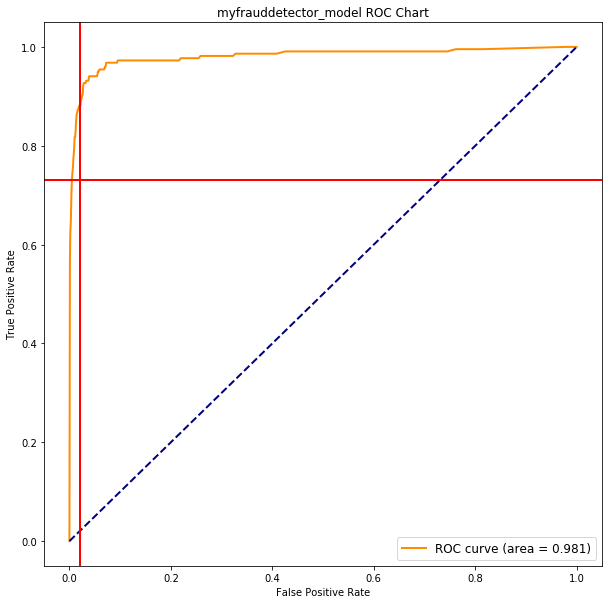

In [42]:
# -- model performance summary -- 
auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

### 6. Create Detector, generate Rules and assemble your Detector

-----
    
<div class="alert alert-info"> 💡 <strong> Generate Rules, Create and Publish a Detector. </strong>
    
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.
</div>

In [43]:
# -- initialize your detector -- 
response = client.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

{'ResponseMetadata': {'RequestId': '39c943d9-d657-465f-b3ed-4818cdd31db5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 18 Feb 2021 07:59:22 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '39c943d9-d657-465f-b3ed-4818cdd31db5'}, 'RetryAttempts': 0}}


In [44]:
# -- make rules -- 
model_stat = df_model.round(decimals=2)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if x['fpr'] == 0.06:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,x['threshold_prev'])
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "fraud"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "investigate"

print (" --- score thresholds 1% to 6% --- ")
print(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))


 --- score thresholds 1% to 6% --- 
    fpr   tpr  threshold                                          rule      outcome
0  0.01  0.74      970.0   $myfrauddetector_model_insightscore > 970.0        fraud
1  0.02  0.87      925.0   $myfrauddetector_model_insightscore > 925.0        fraud
2  0.03  0.90      875.0   $myfrauddetector_model_insightscore > 875.0        fraud
3  0.04  0.93      835.0   $myfrauddetector_model_insightscore > 835.0  investigate
4  0.05  0.94      790.0   $myfrauddetector_model_insightscore > 790.0  investigate
5  0.06  0.95      750.0  $myfrauddetector_model_insightscore <= 790.0      approve


In [45]:
# -- create outcomes -- 
def create_outcomes(outcomes):
    """ create Fraud Detector Outcomes 
    
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = client.put_outcome(
                          name=outcome,
                          description=outcome)

# -- get distinct outcomes 
outcomes = m["outcome"].unique().tolist()

create_outcomes(outcomes)

creating outcome variable: fraud 
creating outcome variable: investigate 
creating outcome variable: approve 


In [46]:
rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = client.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")
rule_list    

creating rule: rule0_myfrauddetector_model: IF $myfrauddetector_model_insightscore > 970.0 THEN fraud
this rule already exists in this detector
creating rule: rule1_myfrauddetector_model: IF $myfrauddetector_model_insightscore > 925.0 THEN fraud
this rule already exists in this detector
creating rule: rule2_myfrauddetector_model: IF $myfrauddetector_model_insightscore > 875.0 THEN fraud
this rule already exists in this detector
creating rule: rule3_myfrauddetector_model: IF $myfrauddetector_model_insightscore > 835.0 THEN investigate
this rule already exists in this detector
creating rule: rule4_myfrauddetector_model: IF $myfrauddetector_model_insightscore > 790.0 THEN investigate
this rule already exists in this detector
creating rule: rule5_myfrauddetector_model: IF $myfrauddetector_model_insightscore <= 790.0 THEN approve
this rule already exists in this detector


[{'ruleId': 'rule0_myfrauddetector_model',
  'ruleVersion': '1',
  'detectorId': 'myfrauddetector'},
 {'ruleId': 'rule1_myfrauddetector_model',
  'ruleVersion': '1',
  'detectorId': 'myfrauddetector'},
 {'ruleId': 'rule2_myfrauddetector_model',
  'ruleVersion': '1',
  'detectorId': 'myfrauddetector'},
 {'ruleId': 'rule3_myfrauddetector_model',
  'ruleVersion': '1',
  'detectorId': 'myfrauddetector'},
 {'ruleId': 'rule4_myfrauddetector_model',
  'ruleVersion': '1',
  'detectorId': 'myfrauddetector'},
 {'ruleId': 'rule5_myfrauddetector_model',
  'ruleVersion': '1',
  'detectorId': 'myfrauddetector'}]

In [47]:
client.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId": MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : "1.0"}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 



 -- detector created -- 
{'ResponseMetadata': {'RequestId': '39c943d9-d657-465f-b3ed-4818cdd31db5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 18 Feb 2021 07:59:22 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '39c943d9-d657-465f-b3ed-4818cdd31db5'}, 'RetryAttempts': 0}}


In [48]:
response = client.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)


 -- detector activated -- 
{'ResponseMetadata': {'RequestId': '5b98fbbe-7504-4c12-913c-43b9fa8ccfc1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 18 Feb 2021 07:59:33 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '5b98fbbe-7504-4c12-913c-43b9fa8ccfc1'}, 'RetryAttempts': 0}}


### 7. Make Predictions 
-----
    
<div class="alert alert-info"> 💡 <strong> Make Predictions. </strong>
    
The following section will apply your detector to the first 10 records in your training dataset. To apply your detector to more simply change the record_count, alternatively you can specify the full training data with the following: 

</div>

```python

record_count = df.shape()[0]

```

In [50]:
record_count = 10 
tmp = df[eventVariables].head(record_count).astype(str).to_dict(orient='records')
tmp[0]

{'transaction_amt': '1606.0',
 'transaction_adj_amt': '33.0',
 'ip_address': '78.237.118.57',
 'email_address': 'toni59@example.org',
 'phone_number': '(565)912-3989',
 'merchant_id': '341-81-5775',
 'billing_city': 'Lake Chloefurt',
 'billing_postal': '90768',
 'billing_state': 'South Dakota',
 'currency': 'eur',
 'cvv': 'V',
 'signature_image': 'B',
 'transaction_type': 'T',
 'transaction_env': 'U',
 'applicant_name': 'Priscilla Rojas',
 'billing_address': '4994 Brown Streets Suite 884'}

In [51]:
df.groupby("EVENT_LABEL").count()

,transaction_amt,transaction_adj_amt,ip_address,email_address,phone_number,merchant_id,billing_city,billing_postal,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address
EVENT_LABEL,,,,,,,,,,,,,,,,,
fraud,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513,1513
legit,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487,28487


In [52]:
# -- this will apply your detector to the first 10 records of your trainig dataset. -- 
predicted_dat = []
pred_data = df[eventVariables].head(record_count).astype(str).to_dict(orient='records')
timestampStr = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
for rec in pred_data:
    eventId = uuid.uuid1()
    pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=rec) 
    
    rec["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
    rec["outcome"] = pred['ruleResults'][0]['outcomes']
    predicted_dat.append(rec)
    

In [53]:
# -- review your predictons -- 
predictions = pd.DataFrame(predicted_dat)
predictions.head()

,transaction_amt,transaction_adj_amt,ip_address,email_address,phone_number,merchant_id,billing_city,billing_postal,billing_state,currency,cvv,signature_image,transaction_type,transaction_env,applicant_name,billing_address,score,outcome
0,1606.0,33.0,78.237.118.57,toni59@example.org,(565)912-3989,341-81-5775,Lake Chloefurt,90768,South Dakota,eur,V,B,T,U,Priscilla Rojas,4994 Brown Streets Suite 884,5.0,[approve]
1,2029.0,37.0,111.127.177.48,msullivan@example.org,9194494367,127-64-4409,West Nicole,63777,Florida,cad,M,M,N,H,Gregory Kelley,9795 Shawn Highway Suite 708,14.0,[approve]
2,2973.0,43.0,51.94.34.207,hannahmacdonald@example.org,+1-502-344-9863x9952,778-86-5127,Lake Kathy,30145,Texas,eur,H,V,X,H,Jeffrey Foster,6124 Melissa Rest,17.0,[approve]
3,1855.0,38.0,191.154.28.61,lestermichael@example.org,208-534-6414x1509,767-64-4433,South Janet,61594,Florida,cad,V,B,T,K,Karen Aguirre,6001 Padilla Flats Apt. 662,9.0,[approve]
4,2254.0,56.0,124.158.55.194,sarah46@example.net,+1-915-631-0497x8327,606-13-4162,East Amanda,15015,Mississippi,eur,X,N,B,B,Robert Smith,8258 Joshua Court,91.0,[approve]


### Optionally Write Predictions to File

<div class="alert alert-info"> 💡 <strong> Write Predictions. </strong>

- You can write your prediction dataset to a CSV or Excel to manually review predictions
- Simply add a cell below and copy the code below

</div>



```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(MODEL_NAME + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(MODEL_NAME + ".xlsx", index=False)

```